In [113]:
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

df = pd.read_csv('./Dataset/umist_faces.csv')




In [114]:
df.shape

(575, 10305)

In [115]:
duplicates = df.duplicated()
num_duplicates = duplicates.sum()

duplicates = df[duplicates]


if not duplicates.empty:
    print(f"Found {len(duplicates)} duplicate rows:")
    print(duplicates)
else:
    print("No duplicate rows found in the DataFrame.")

Found 10 duplicate rows:
   label  pixel_0  pixel_1  pixel_2  pixel_3  pixel_4  pixel_5  pixel_6  \
63    1b    230.0    230.0    232.0    230.0    233.0    232.0    232.0   
64    1b    233.0    232.0    233.0    232.0    233.0    234.0    230.0   
65    1b    234.0    233.0    234.0    234.0    234.0    233.0    234.0   
66    1b    233.0    233.0    234.0    233.0    233.0    234.0    234.0   
67    1b    234.0    233.0    234.0    234.0    234.0    233.0    234.0   
68    1b    234.0    233.0    234.0    234.0    234.0    234.0    234.0   
69    1b    234.0    234.0    233.0    234.0    233.0    234.0    233.0   
70    1b    234.0    234.0    234.0    234.0    234.0    234.0    234.0   
71    1b    234.0    234.0    234.0    234.0    234.0    234.0    232.0   
72    1b    221.0    209.0    140.0     86.0     83.0     74.0     66.0   

    pixel_7  pixel_8  ...  pixel_10294  pixel_10295  pixel_10296  pixel_10297  \
63    232.0    229.0  ...        113.0        122.0        127.0    

In [116]:
if num_duplicates > 0:
    df = df.drop_duplicates()
    print(f"Duplicates removed. New dataset shape: {df.shape}")
else:
    print("No duplicates found in the dataset.")

Duplicates removed. New dataset shape: (565, 10305)


In [117]:
missing_values = df.isnull().sum().sum()
if missing_values > 0:
    print(f"Dataset contains {missing_values} missing values. Cleaning is required.")
    df = df.dropna()
else:
    print("No missing values found in the dataset.")

No missing values found in the dataset.


In [118]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [119]:
X = df.drop('label', axis=1).values
y = df['label']

In [120]:
# Reshape images (assuming 112x92 image size)
image_size = (112, 92)
X = X.reshape(-1, *image_size)

In [121]:
from sklearn.model_selection import train_test_split
# Split data into training, testing, and validation sets using stratified sampling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

c:\Users\vishw\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\vishw\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\vishw\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\vishw\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a

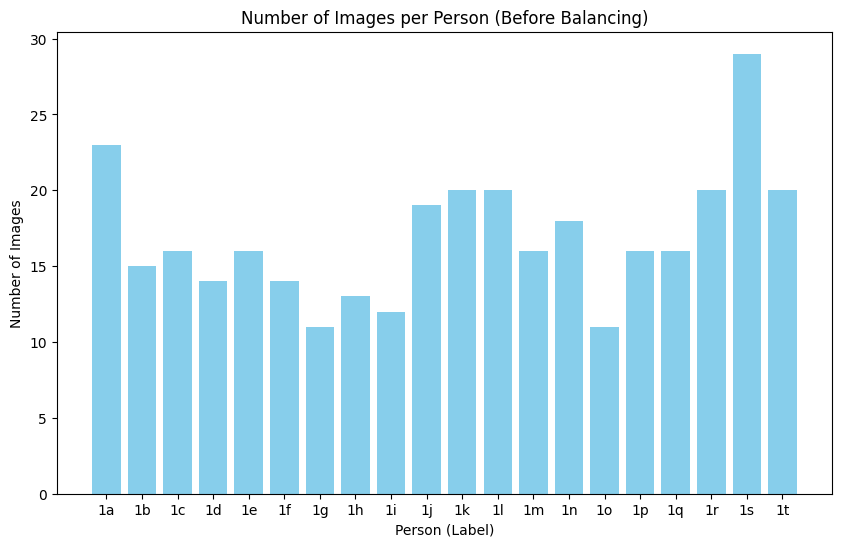

Balanced dataset shape: (960, 112, 92, 1), (960,)


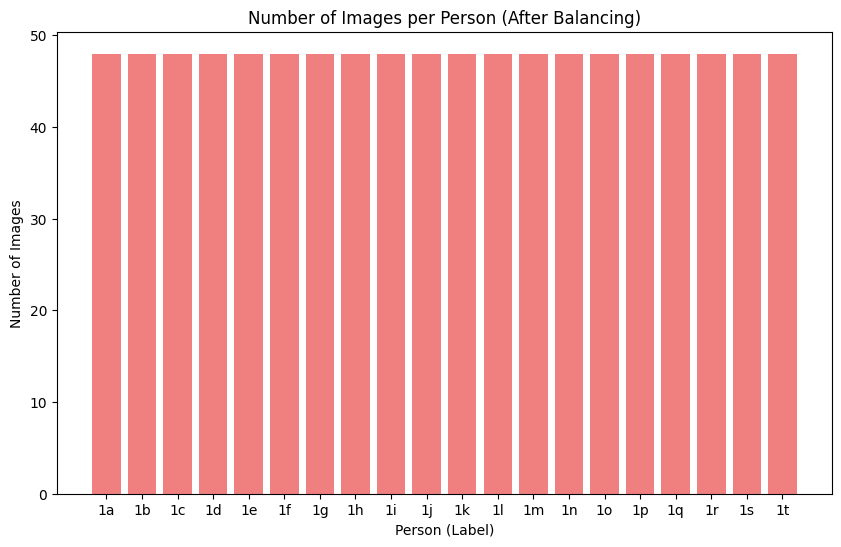

In [122]:
# Balance the training dataset using ImageDataGenerator
TARGET_IMAGES_PER_PERSON = 48

# Split the dataset by label
unique_labels = np.unique(y_train)
label_to_images = {label: X_train[y_train == label] for label in unique_labels}

# Create an ImageDataGenerator instance for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Before balancing: plot the number of images per person
initial_counts = [np.sum(y_train == label) for label in unique_labels]
plt.figure(figsize=(10, 6))
plt.bar(unique_labels, initial_counts, color='skyblue')
plt.title('Number of Images per Person (Before Balancing)')
plt.xlabel('Person (Label)')
plt.ylabel('Number of Images')
plt.show()

balanced_X = []
balanced_y = []

for label, images in label_to_images.items():
    num_images = images.shape[0]
    if num_images < TARGET_IMAGES_PER_PERSON:
        # Add channel dimension to images (assuming grayscale images)
        images = np.expand_dims(images, axis=-1)  # Shape becomes (num_images, height, width, 1)
        
        # Generate augmented images
        augmented_images = []
        for x in datagen.flow(images, batch_size=1, seed=42):
            augmented_images.append(x[0])  # x is a batch, take the first image
            if len(augmented_images) + num_images >= TARGET_IMAGES_PER_PERSON:
                break
        combined_images = np.concatenate([images, np.array(augmented_images)])
    else:
        # Randomly select TARGET_IMAGES_PER_PERSON images
        combined_images = images[np.random.choice(num_images, TARGET_IMAGES_PER_PERSON, replace=False)]

    balanced_X.extend(combined_images)
    balanced_y.extend([label] * TARGET_IMAGES_PER_PERSON)

# Convert balanced dataset to numpy arrays
balanced_X = np.array(balanced_X)
balanced_y = np.array(balanced_y)

print(f"Balanced dataset shape: {balanced_X.shape}, {balanced_y.shape}")

# After balancing: plot the number of images per person
balanced_counts = [np.sum(balanced_y == label) for label in unique_labels]
plt.figure(figsize=(10, 6))
plt.bar(unique_labels, balanced_counts, color='lightcoral')
plt.title('Number of Images per Person (After Balancing)')
plt.xlabel('Person (Label)')
plt.ylabel('Number of Images')
plt.show()

In [123]:
X_train = balanced_X.reshape(balanced_X.shape[0], -1)
y_train = balanced_y

In [124]:
train_images = X_train.reshape(-1, 112, 92).astype(np.float32)
val_images = X_val.reshape(-1, 112, 92).astype(np.float32)
test_images = X_test.reshape(-1, 112, 92).astype(np.float32)

images /= 255.0

train_labels = y_train
val_labels = y_val
test_labels = y_test

In [125]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_cnn_model(input_shape=(112, 92, 1), embedding_dim=128):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=3, activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=2),
        layers.Conv2D(64, kernel_size=3, activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=2),
        layers.Conv2D(128, kernel_size=3, activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=2),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(embedding_dim, activation=None)
    ])
    return model


In [126]:
embedding_dim = 128 
input_shape = (112, 92, 1)  
cnn_model = create_cnn_model(input_shape, embedding_dim)

cnn_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 112, 92, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 56, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 46, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 28, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 23, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 19712)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     5,046,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,172,096 (19.73 MB)

 Trainable params: 5,172,096 (19.73 MB)

 Non-trainable params: 0 (0.00 B)

In [127]:
train_images = train_images[..., np.newaxis]
val_images = val_images[..., np.newaxis]
test_images = test_images[..., np.newaxis]

In [128]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)
test_labels_encoded = label_encoder.transform(test_labels)

print(f"Train Images Shape: {train_images.shape}")
print(f"Validation Images Shape: {val_images.shape}")
print(f"Test Images Shape: {test_images.shape}")

Train Images Shape: (960, 112, 92, 1)
Validation Images Shape: (113, 112, 92, 1)
Test Images Shape: (113, 112, 92, 1)


c:\Users\vishw\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\vishw\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\vishw\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\vishw\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a

In [129]:
from tensorflow.keras import optimizers

# Add classification head
classification_model = models.Sequential([
    cnn_model,
    layers.Dense(len(unique_labels), activation='softmax')
])

# Compile the model
classification_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = classification_model.fit(
    train_images, train_labels_encoded,
    validation_data=(val_images, val_labels_encoded),
    epochs=10,
    batch_size=32
)

Epoch 1/10


30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 0.0860 - loss: 26.8642 - val_accuracy: 0.6460 - val_loss: 1.4645
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 0.4779 - loss: 1.7022 - val_accuracy: 0.9115 - val_loss: 0.4304
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 0.7580 - loss: 0.7823 - val_accuracy: 0.8850 - val_loss: 0.2234
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 0.9006 - loss: 0.3567 - val_accuracy: 0.8850 - val_loss: 0.5821
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 0.9451 - loss: 0.1756 - val_accuracy: 0.9558 - val_loss: 0.1634
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 0.9784 - loss: 0.0872 - val_accuracy: 0.8938 - val_loss: 0.5298
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 0.9758 - loss: 0.1183 - val_accuracy: 0.9469 - val_loss: 0.2737
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.9748 - loss: 0.0920 - val_accuracy: 0.9115 - val

In [130]:
feature_extractor = cnn_model

train_embeddings = feature_extractor.predict(train_images)
val_embeddings = feature_extractor.predict(val_images)
test_embeddings = feature_extractor.predict(test_images)

print(f"Train Embeddings Shape: {train_embeddings.shape}")
print(f"Validation Embeddings Shape: {val_embeddings.shape}")
print(f"Test Embeddings Shape: {test_embeddings.shape}")

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Train Embeddings Shape: (960, 128)
Validation Embeddings Shape: (113, 128)
Test Embeddings Shape: (113, 128)


K-Means CLUSTERING


In [131]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

num_clusters = len(unique_labels)
kmeans = KMeans(n_clusters=num_clusters, random_state=32)
cluster_labels = kmeans.fit_predict(train_embeddings)

silhouette_avg = silhouette_score(train_embeddings, cluster_labels)
print(f"Silhouette Score: {silhouette_avg:.4f}")

c:\Users\vishw\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score: 0.1179


In [132]:
def find_optimal_clusters(embeddings, max_clusters=10):
    silhouette_avgs = []
    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=32)
        cluster_labels = kmeans.fit_predict(embeddings)
        silhouette_avg = silhouette_score(embeddings, cluster_labels)
        silhouette_avgs.append((n_clusters, silhouette_avg))
    return silhouette_avgs

max_clusters = 50
silhouette_avgs = find_optimal_clusters(train_embeddings, max_clusters=max_clusters)


c:\Users\vishw\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\vishw\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\vishw\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\vishw\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value 

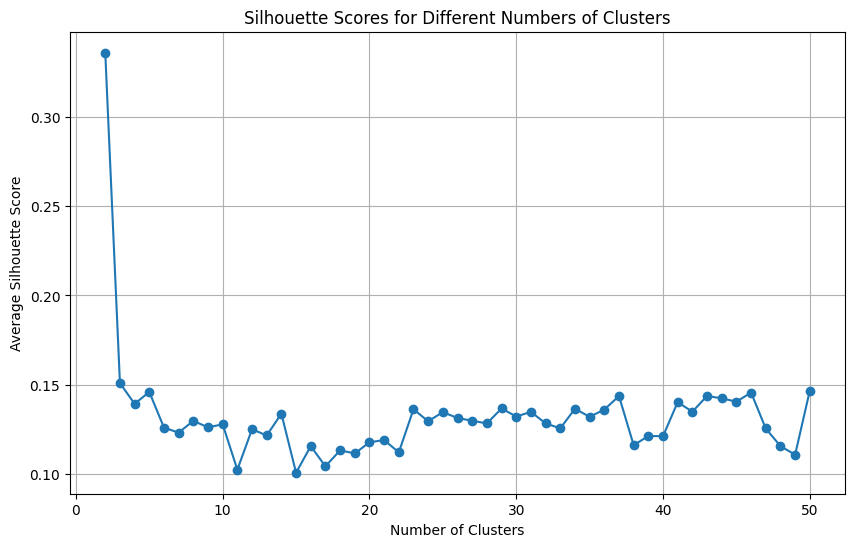

The optimal number of clusters is 2 with a silhouette score of 0.3357.


In [133]:
clusters, scores = zip(*silhouette_avgs)
plt.figure(figsize=(10, 6))
plt.plot(clusters, scores, marker='o')
plt.title("Silhouette Scores for Different Numbers of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Average Silhouette Score")
plt.grid(True)
plt.show()

# Find and print the optimal number of clusters
optimal_clusters = clusters[np.argmax(scores)]
print(f"The optimal number of clusters is {optimal_clusters} with a silhouette score of {max(scores):.4f}.")

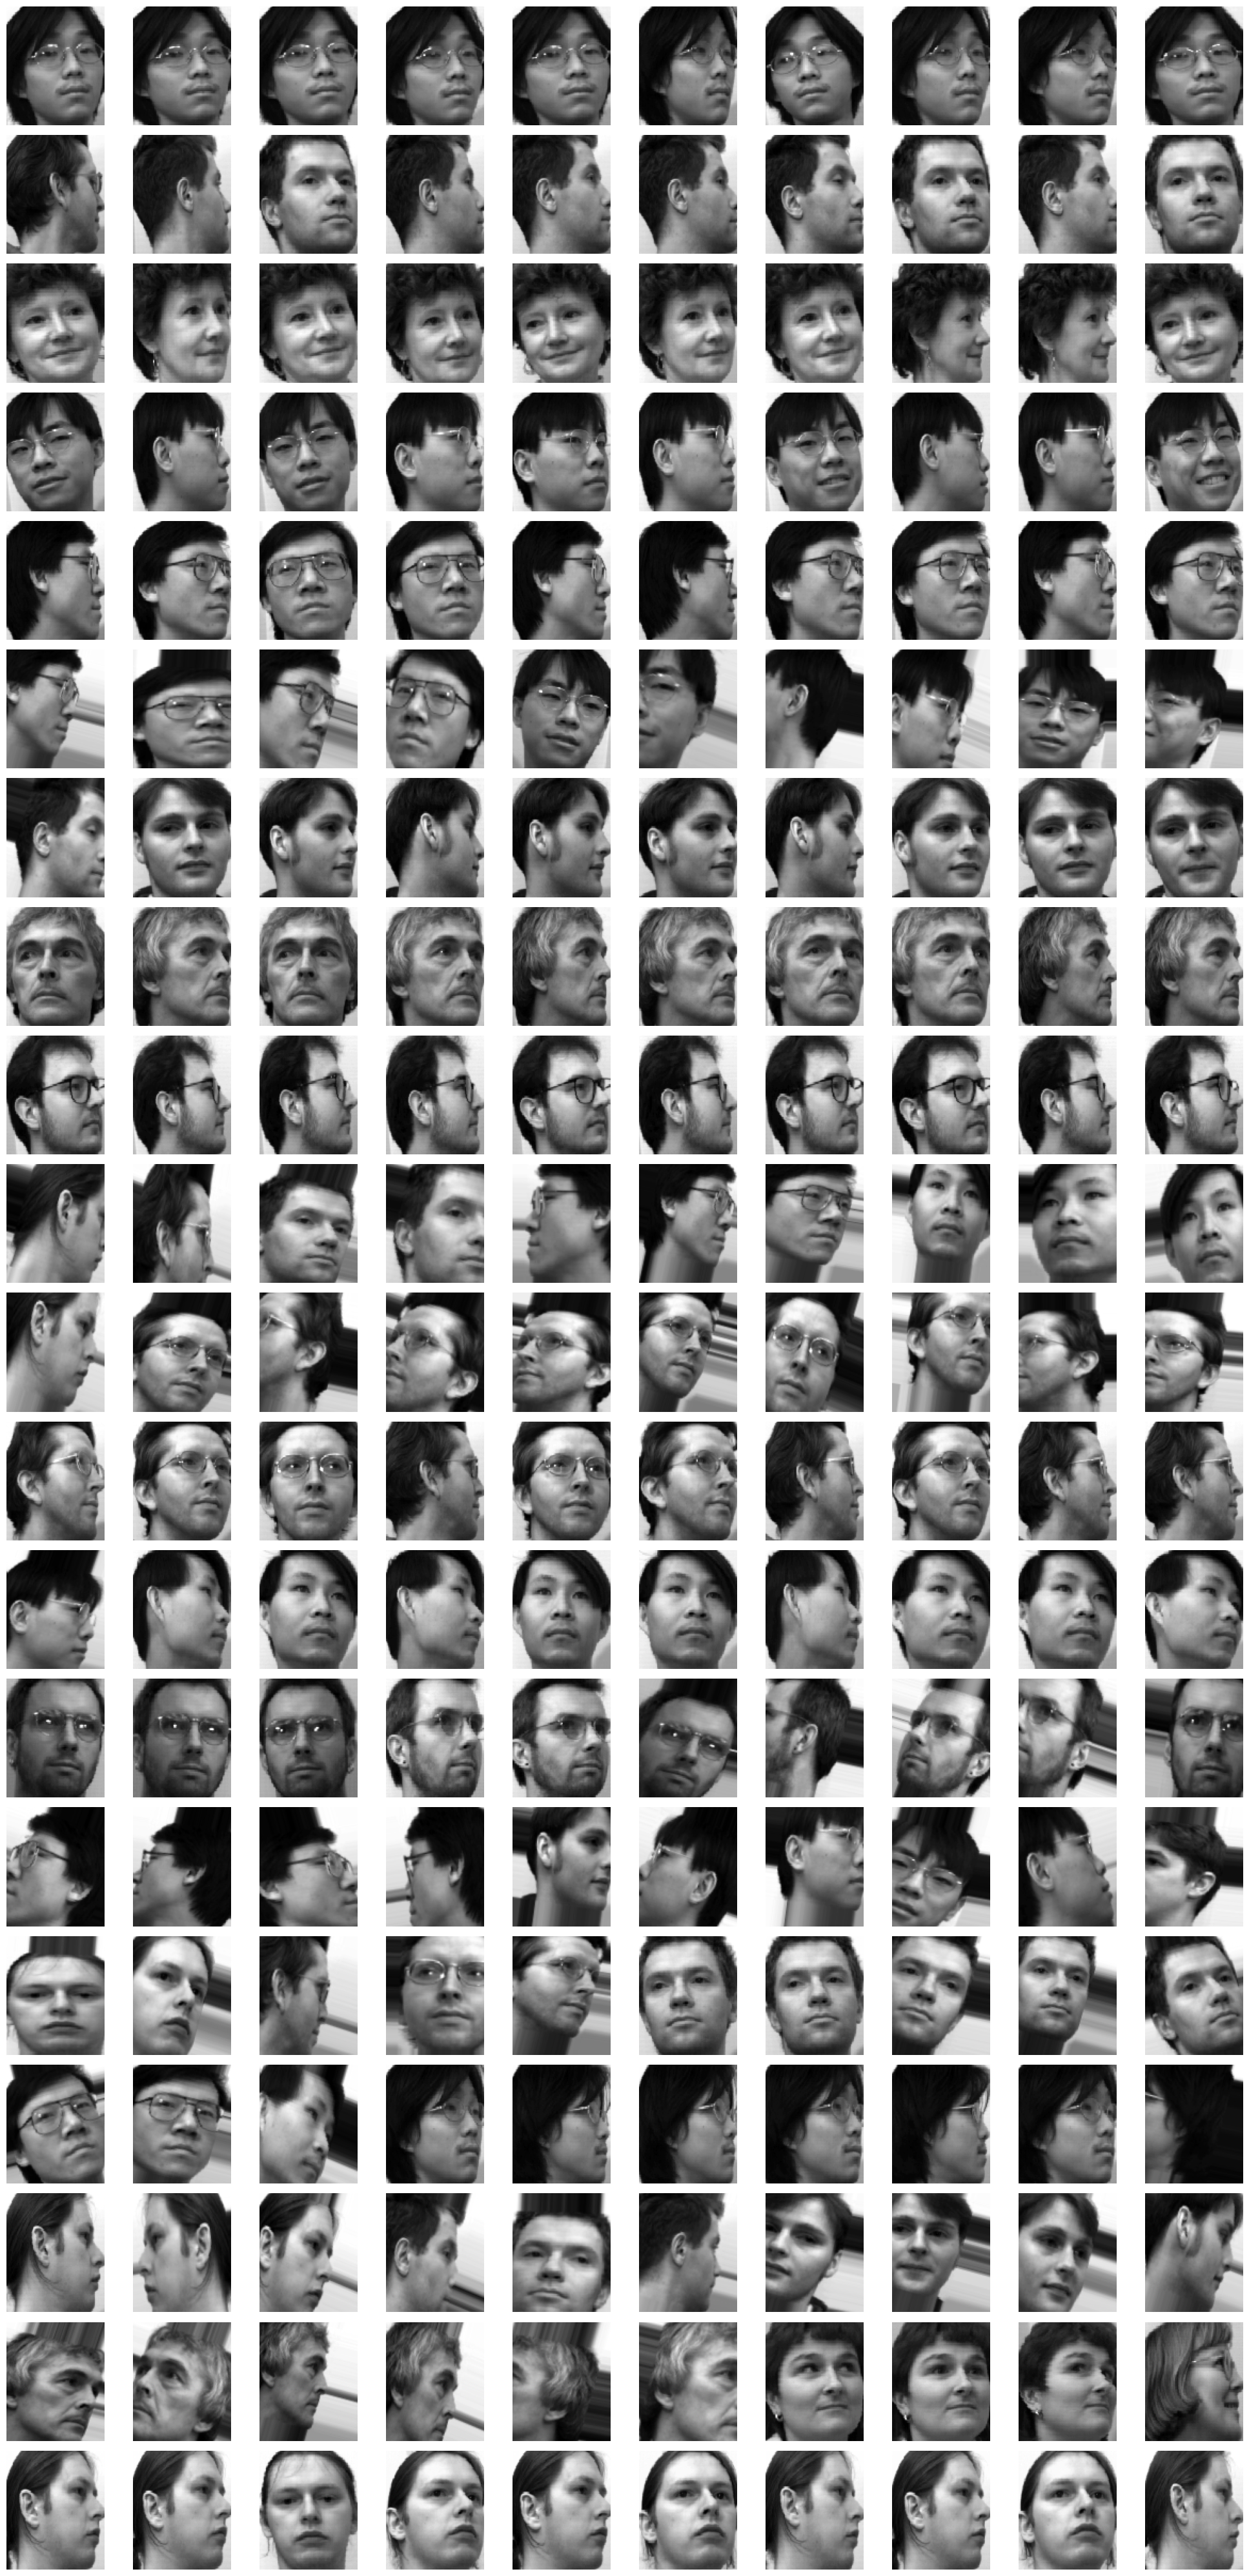

In [134]:
def group_images_by_cluster(images, cluster_labels):
    clusters = {}
    for idx, cluster in enumerate(cluster_labels):
        if cluster not in clusters:
            clusters[cluster] = []
        clusters[cluster].append(images[idx])
    return clusters

clusters = group_images_by_cluster(train_images, cluster_labels)

def plot_clusters(clusters, images_per_cluster=10):
    num_clusters = len(clusters)
    fig, axes = plt.subplots(num_clusters, images_per_cluster, figsize=(images_per_cluster * 2, num_clusters * 2))
    for cluster_id, image_list in clusters.items():
        for i in range(min(len(image_list), images_per_cluster)):
            ax = axes[cluster_id, i] if num_clusters > 1 else axes[i]
            ax.imshow(image_list[i], cmap='gray')
            ax.axis('off')
        for j in range(len(image_list), images_per_cluster):
            ax = axes[cluster_id, j] if num_clusters > 1 else axes[j]
            ax.axis('off')
    plt.tight_layout()
    plt.show()

plot_clusters(clusters, images_per_cluster=10)


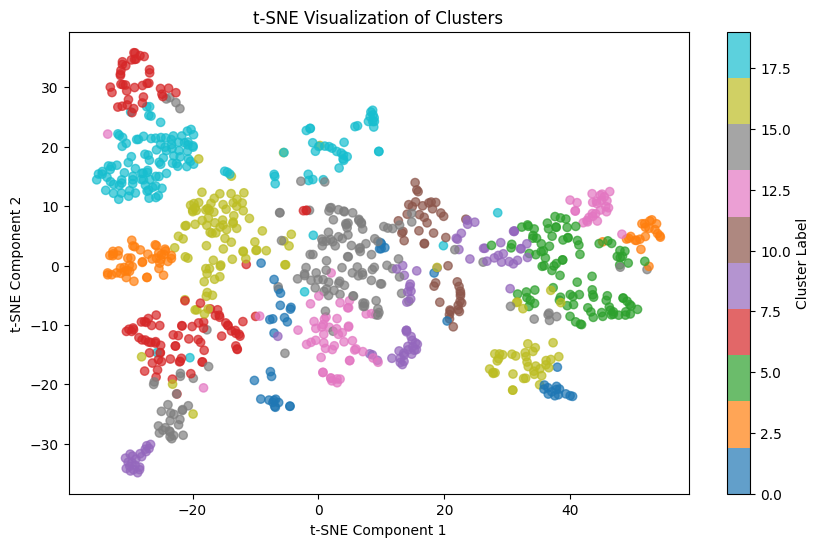

In [135]:
from sklearn.manifold import TSNE

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=32)
tsne_embeddings = tsne.fit_transform(train_embeddings)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    tsne_embeddings[:, 0],
    tsne_embeddings[:, 1],
    c=cluster_labels,
    cmap="tab10",
    alpha=0.7,
)
plt.colorbar(scatter, label="Cluster Label")
plt.title("t-SNE Visualization of Clusters")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()


IndexError: index 19 is out of bounds for axis 0 with size 19

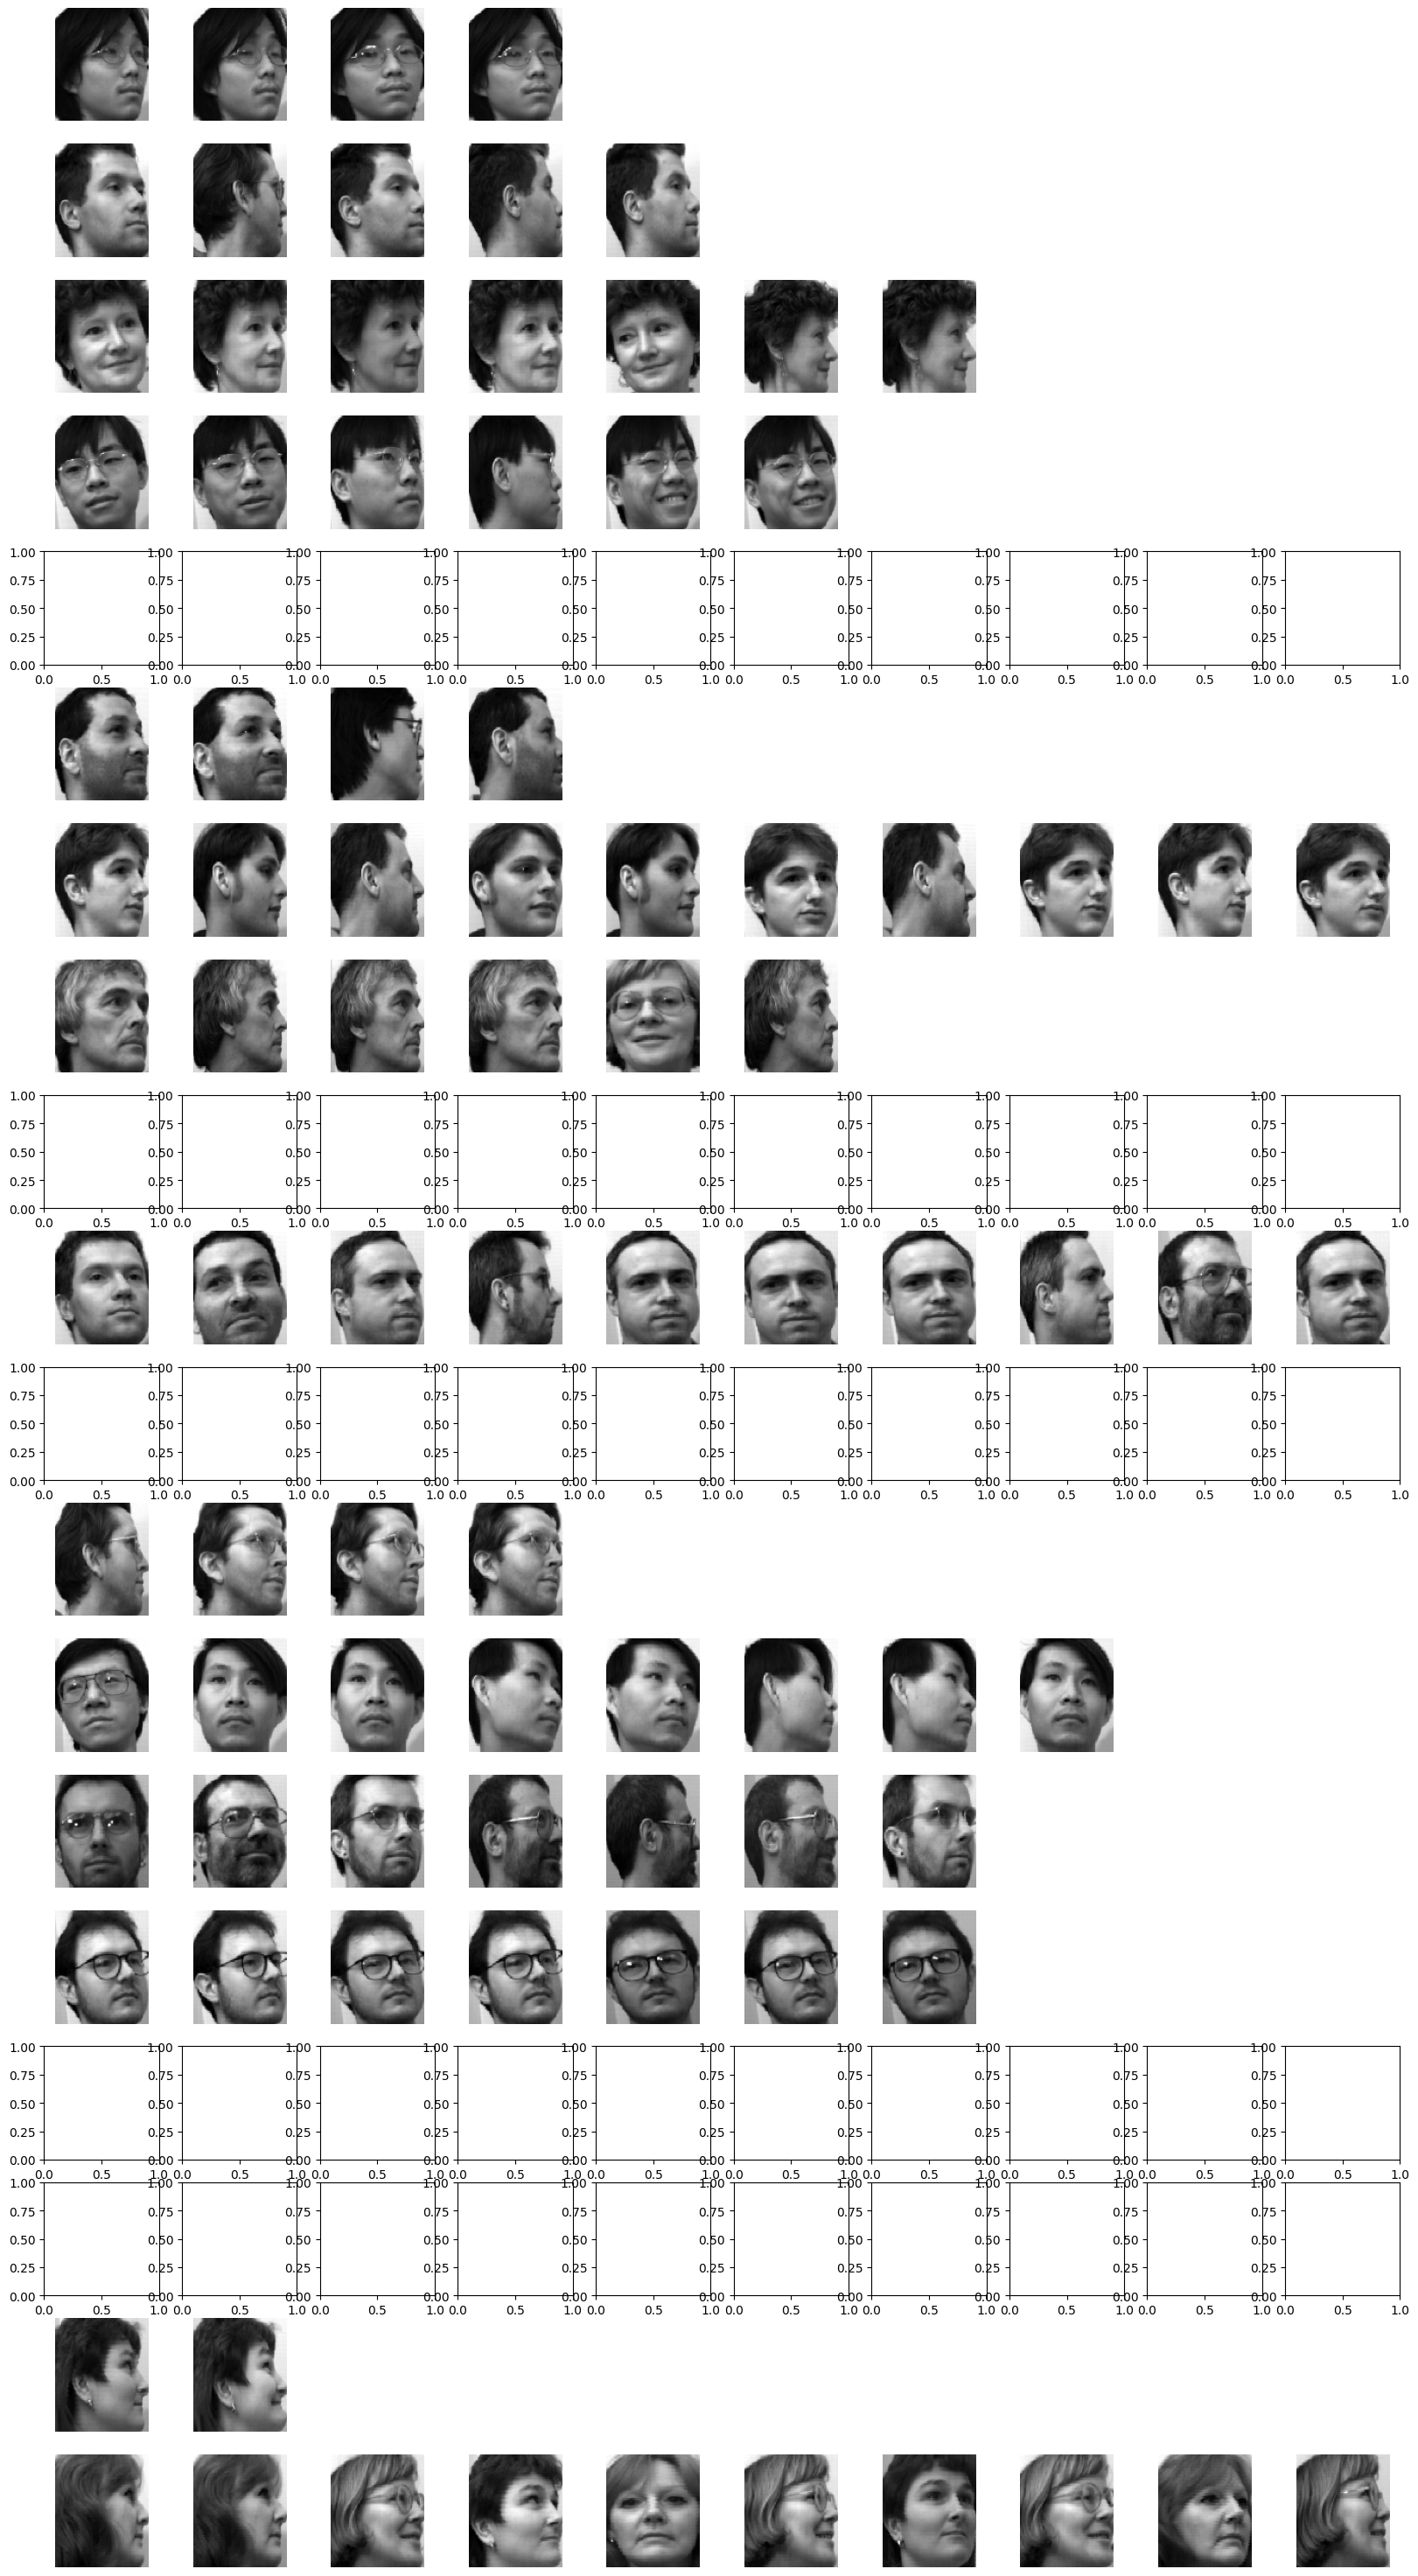

In [136]:
# Group images by cluster
def group_images_by_cluster(images, cluster_labels):
    clusters = {}
    for idx, cluster in enumerate(cluster_labels):
        if cluster not in clusters:
            clusters[cluster] = []
        clusters[cluster].append(images[idx])
    return clusters

def plot_clusters_with_title(clusters, images_per_cluster=10, title="Cluster Visualization"):
    num_clusters = len(clusters)
    fig, axes = plt.subplots(num_clusters, images_per_cluster, figsize=(images_per_cluster * 2, num_clusters * 2))
    for cluster_id, image_list in clusters.items():
        for i in range(min(len(image_list), images_per_cluster)):
            ax = axes[cluster_id, i] if num_clusters > 1 else axes[i]
            ax.imshow(image_list[i].squeeze(), cmap='gray')
            ax.axis('off')
        for j in range(len(image_list), images_per_cluster):
            ax = axes[cluster_id, j] if num_clusters > 1 else axes[j]
            ax.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

val_cluster_labels = kmeans.predict(val_embeddings) 
test_cluster_labels = kmeans.predict(test_embeddings) 

val_clusters = group_images_by_cluster(val_images, val_cluster_labels)  
test_clusters = group_images_by_cluster(test_images, test_cluster_labels)  

plot_clusters_with_title(val_clusters, images_per_cluster=10, title="Validation Set Clusters")
plot_clusters_with_title(test_clusters, images_per_cluster=10, title="Test Set Clusters")


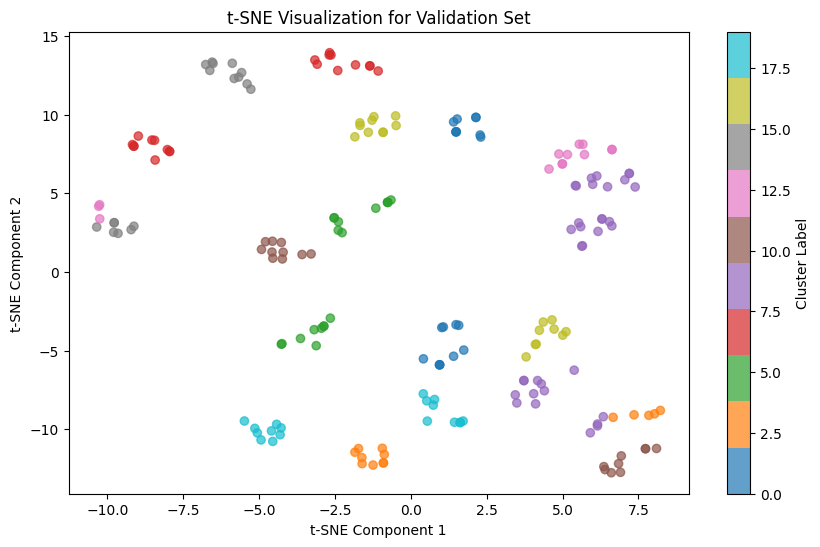

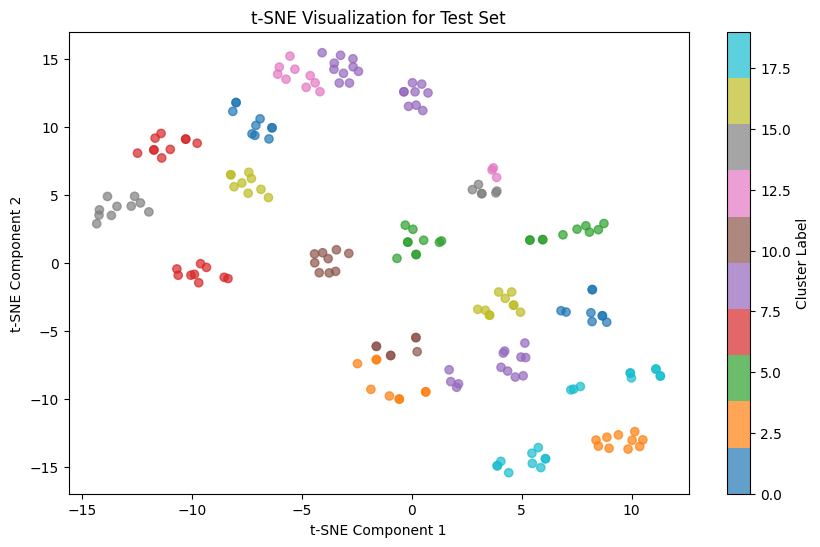

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_tsne(embeddings, labels, title="t-SNE Visualization"):
    tsne = TSNE(n_components=2, random_state=32, perplexity=30)
    tsne_results = tsne.fit_transform(embeddings)
    
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(
        tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap="tab10", alpha=0.7
    )
    plt.colorbar(scatter, label="Cluster Label")
    plt.title(title)
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.show()

val_labels = kmeans.predict(val_embeddings)
test_labels = kmeans.predict(test_embeddings)

plot_tsne(val_embeddings, val_labels, title="t-SNE Visualization for Validation Set")
plot_tsne(test_embeddings, test_labels, title="t-SNE Visualization for Test Set")
